In [1]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)

In [2]:
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns
import numpy             as np

from prettytable           import PrettyTable
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from utils  import remove_corr, log_transform
from config import PATH, THRESHOLDS, RT_UNDER_COLUMNS, EXCLUDE_COLUMNS

In [3]:
EXCLUDE_COLUMNS.append('tweet')

In [4]:
df_og    = pd.read_csv('../' + PATH + 'dataset_enhanced.csv')
users_df = pd.read_csv('../' + PATH + 'user_dataset.csv')

df = df_og.copy()

df = df.merge(users_df, left_on='poster', right_on='user_id', how='left')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2139 entries, 0 to 2138
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            2139 non-null   int64  
 1   tweet               2139 non-null   object 
 2   label               2139 non-null   object 
 3   poster              2139 non-null   int64  
 4   num_rt              2139 non-null   int64  
 5   depth_max           2139 non-null   int64  
 6   depth_avg           2139 non-null   float64
 7   time_total          2139 non-null   float64
 8   time_avg            2139 non-null   float64
 9   rts_half_life       2139 non-null   float64
 10  num_circles         2139 non-null   int64  
 11  rts_under_5_min     2139 non-null   int64  
 12  rts_under_30_min    2139 non-null   int64  
 13  rts_under_60_min    2139 non-null   int64  
 14  rts_under_180_min   2139 non-null   int64  
 15  rts_under_480_min   2139 non-null   int64  
 16  rts_un

In [6]:
def create_summary(df, chunk_size = 4):
    df_filtered = df.drop(columns=EXCLUDE_COLUMNS).drop(columns = ['tweet_id', 'user_id'])

    desc_df = df_filtered.describe().round(2).drop(index="count")
    desc_df.loc["median"] = df_filtered.median().round(2)

    for i in range(0, desc_df.shape[1], chunk_size):
        print(desc_df.iloc[:, i:i+chunk_size])
        print("\n" + "-"*50 + "\n")

    return None

create_summary(df, 3)

         num_rt  depth_max  depth_avg
mean     420.98       3.70       1.29
std      440.49       1.59       0.32
min       54.00       1.00       0.99
25%      155.00       3.00       1.08
50%      274.00       3.00       1.18
75%      489.50       4.00       1.40
max     3124.00      16.00       5.12
median   274.00       3.00       1.18

--------------------------------------------------

        time_total    time_avg  rts_half_life
mean      69935.04     2945.01           0.98
std      165002.15    52346.76           0.07
min          52.38        6.48           0.00
25%        4117.19      146.76           0.98
50%       11707.03      327.54           0.99
75%       50559.50      831.62           1.00
max     2675420.55  2373113.04           1.00
median    11707.03      327.54           0.99

--------------------------------------------------

        num_circles  rts_under_5_min  rts_under_30_min
mean           2.24            57.66            156.45
std            6.45         

In [7]:
# remove all_caps count, all 0
df = df.drop(columns = ['num_all_caps'])

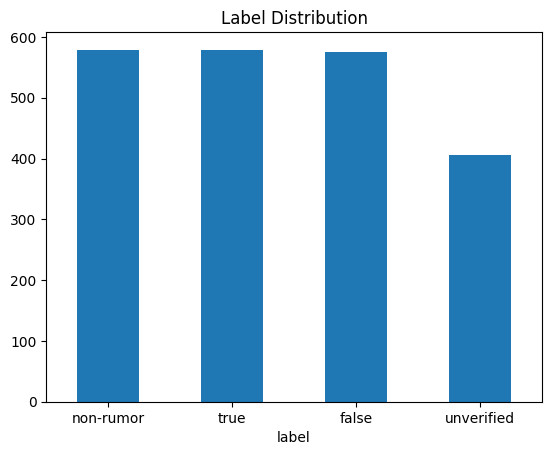

In [8]:
ax = df['label'].value_counts().plot(kind='bar', title="Label Distribution")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.show()

In [9]:
# total retweets vs day 1 retweets
total_rts = df['num_rt'].sum()
d1_rts    = df['rts_under_1440_min'].sum()
print(f'total retweets: {total_rts}')
print(f'day 1 retweets: {d1_rts}')
print(f'percentage:     {d1_rts/total_rts}')

total retweets: 900478
day 1 retweets: 811053
percentage:     0.9006916326662062


In [10]:
# mapping and separation
label_mapping = {label: idx for idx, label in enumerate(sorted(set(df['label'])))}
print('Label Mapping')
print(label_mapping)
df['label'] = df['label'].map(label_mapping)

dfs    = []
titles = []
for t, l in label_mapping.items():
    dfs.append(df[df['label'] == l])
    titles.append(t)

Label Mapping
{'false': 0, 'non-rumor': 1, 'true': 2, 'unverified': 3}


In [12]:
def plot_avg_retweet_speed(dfs, titles):
    plt.figure(figsize=(12, 8))
    
    for df, t in zip(dfs, titles):
        average_retweets = df[RT_UNDER_COLUMNS].mean()
        plt.plot(THRESHOLDS[1:], average_retweets, label=t)
    
    plt.xlabel('Time (minutes)')
    plt.ylabel('AVG # Retweets')
    plt.title('Comparison of AVG Retweets Over Time - Day 1')
    plt.legend()
    plt.show()

    return None

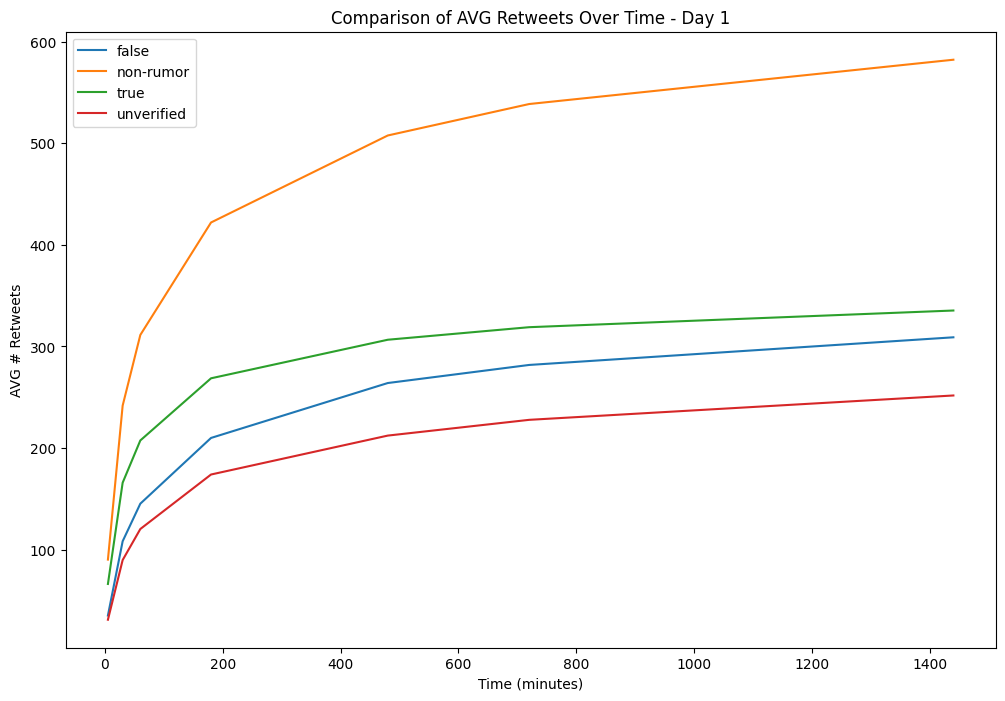

In [13]:
plot_avg_retweet_speed(dfs, titles)

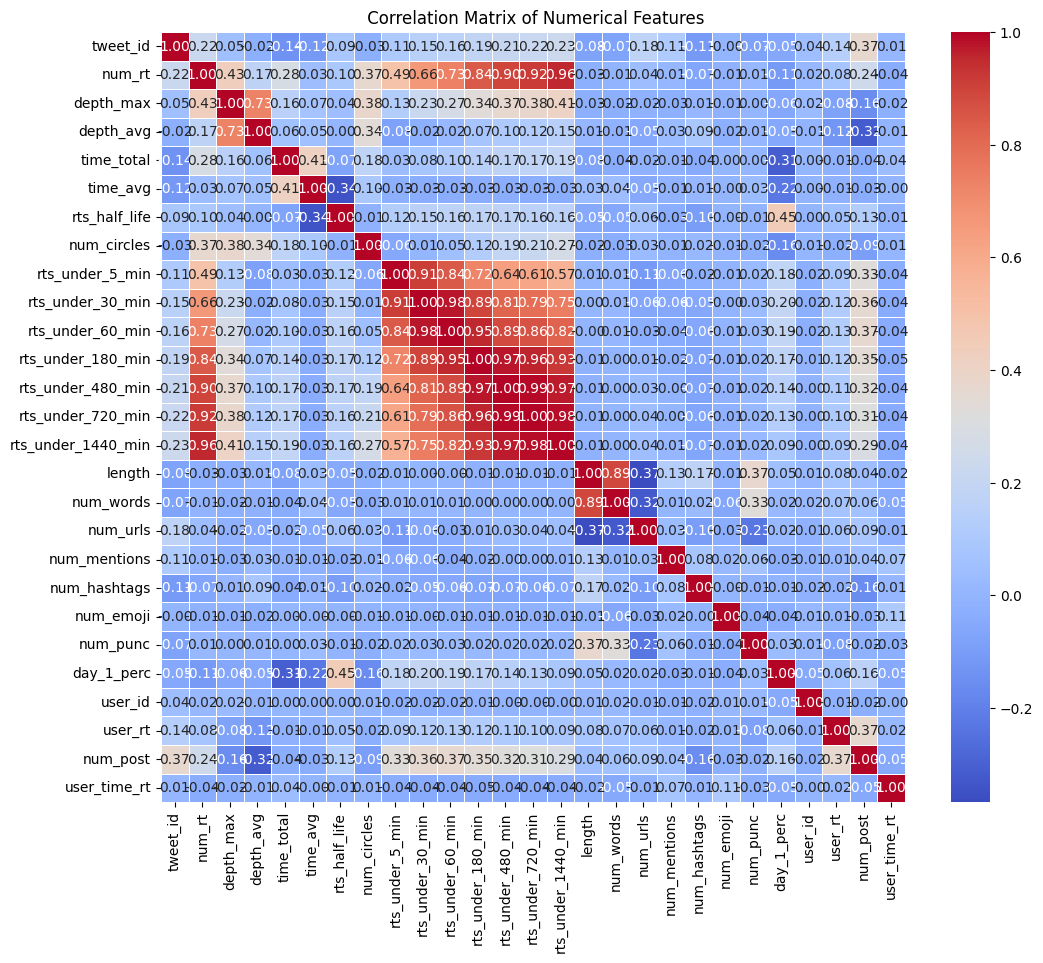

In [14]:
def correlation(df, title = ''):
    df_filtered = df.drop(columns=EXCLUDE_COLUMNS)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(df_filtered.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title(f"{title} Correlation Matrix of Numerical Features")
    plt.show()

def correlation_per_label(dfs, titles):
    for dfi, t in zip(dfs, titles):
        correlation(dfi, t)
        
correlation(df)

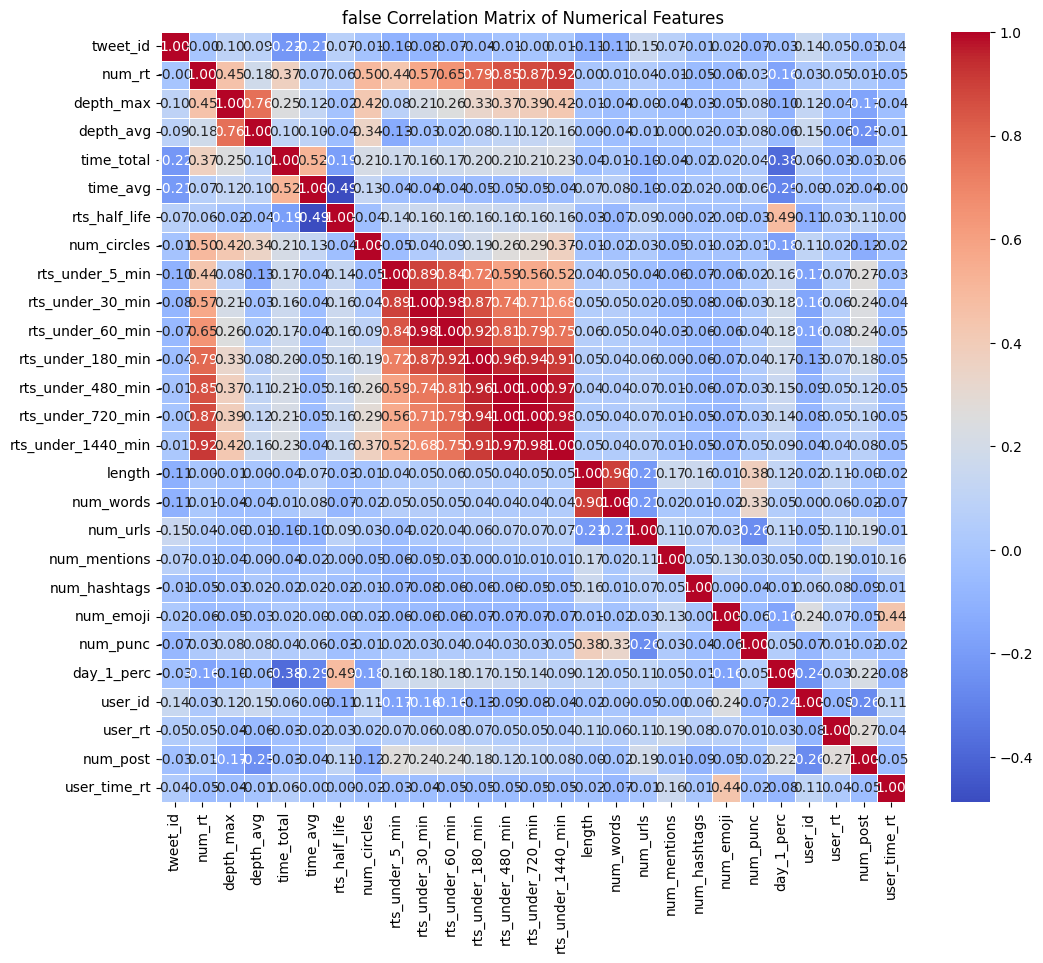

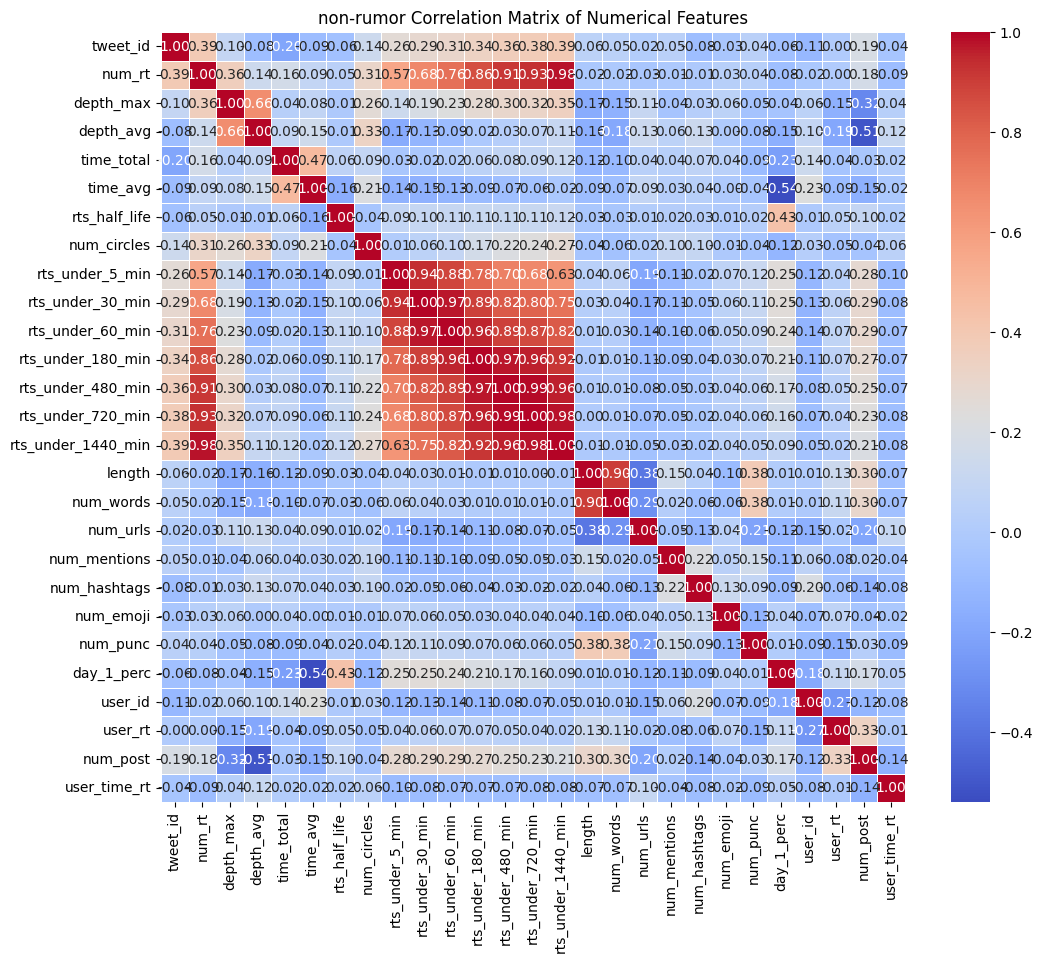

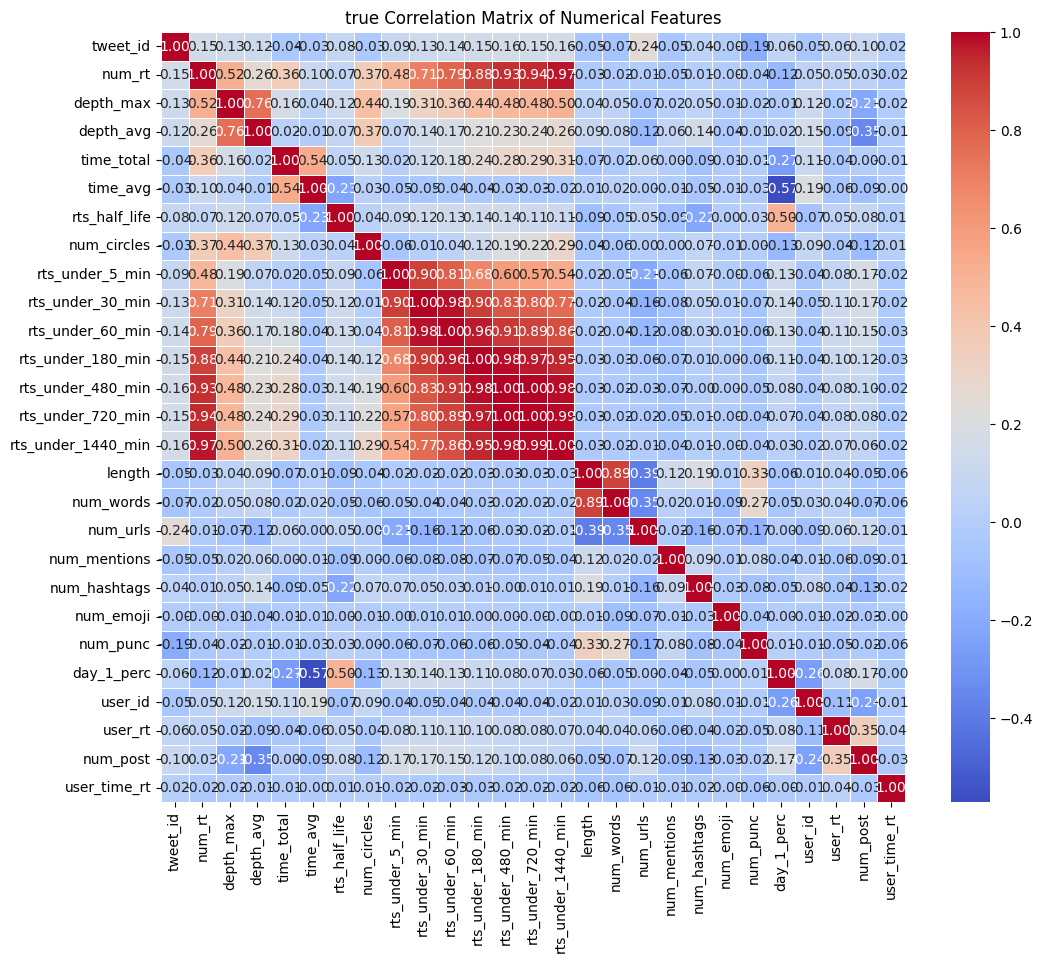

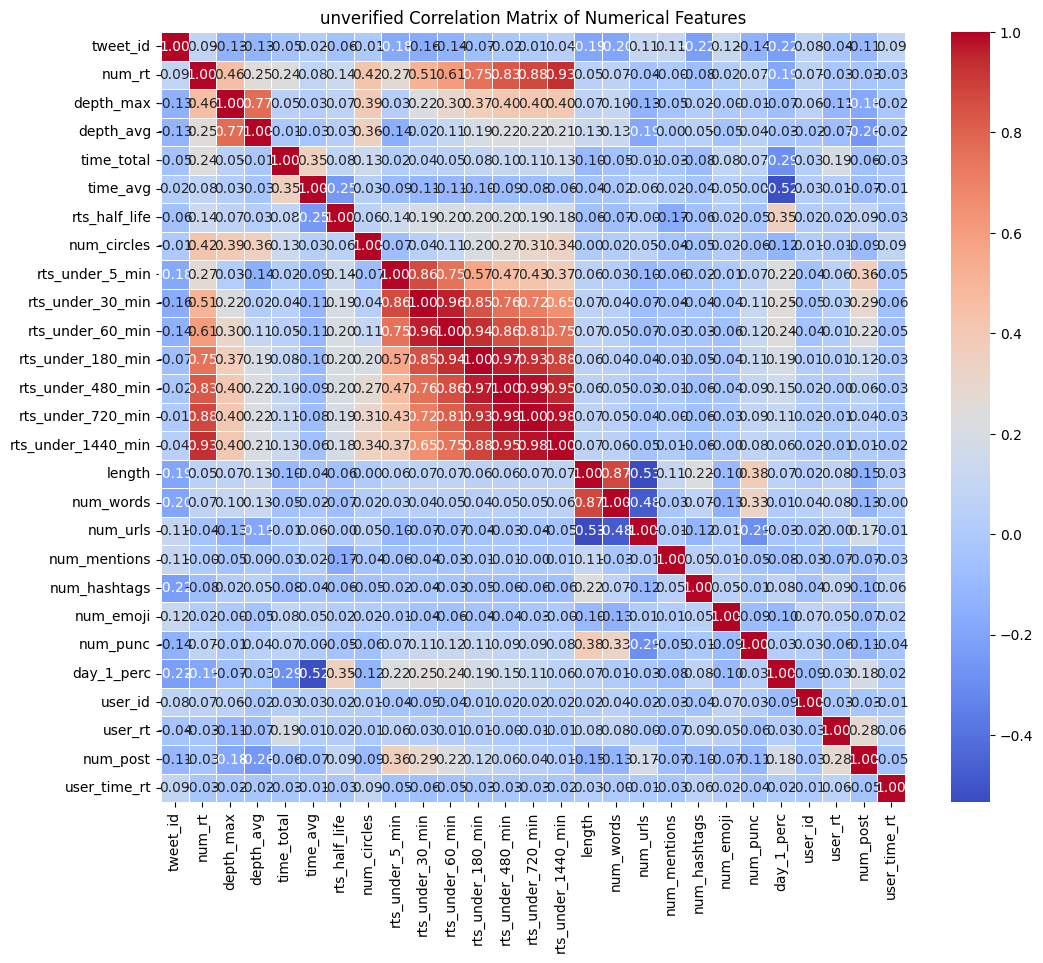

In [15]:
correlation_per_label(dfs, titles)

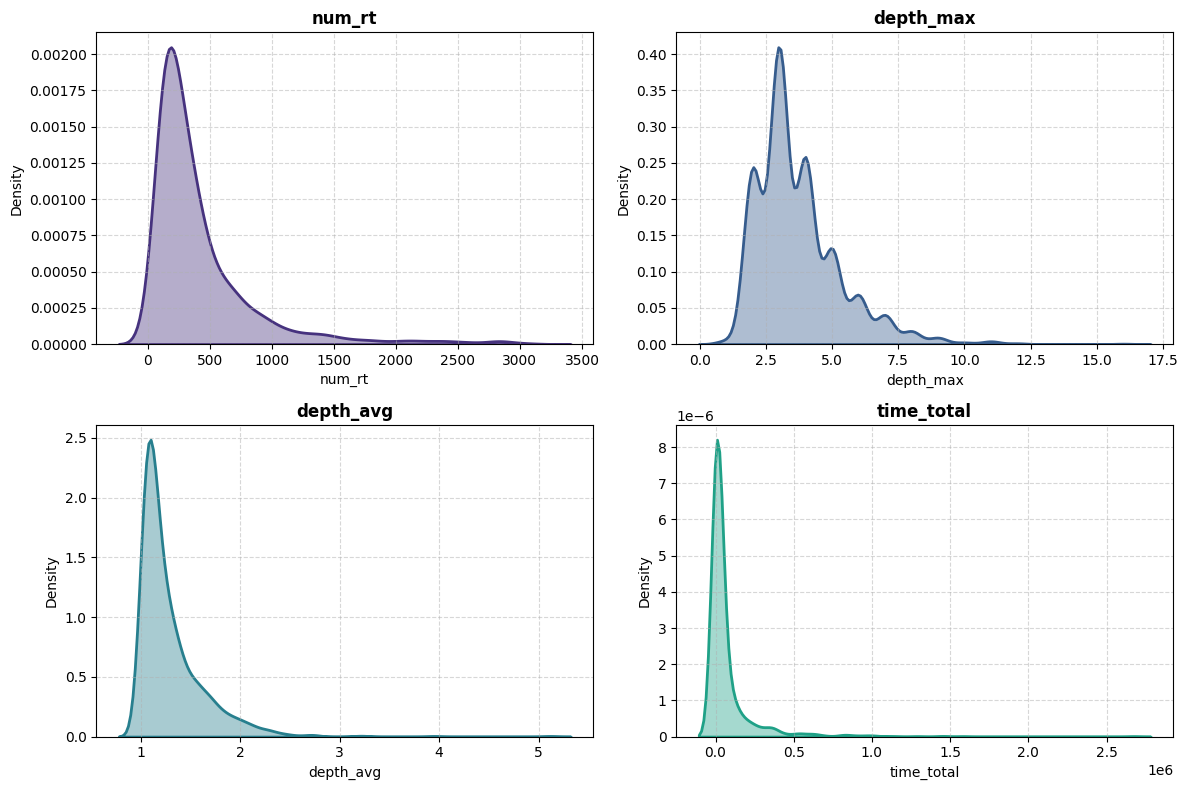

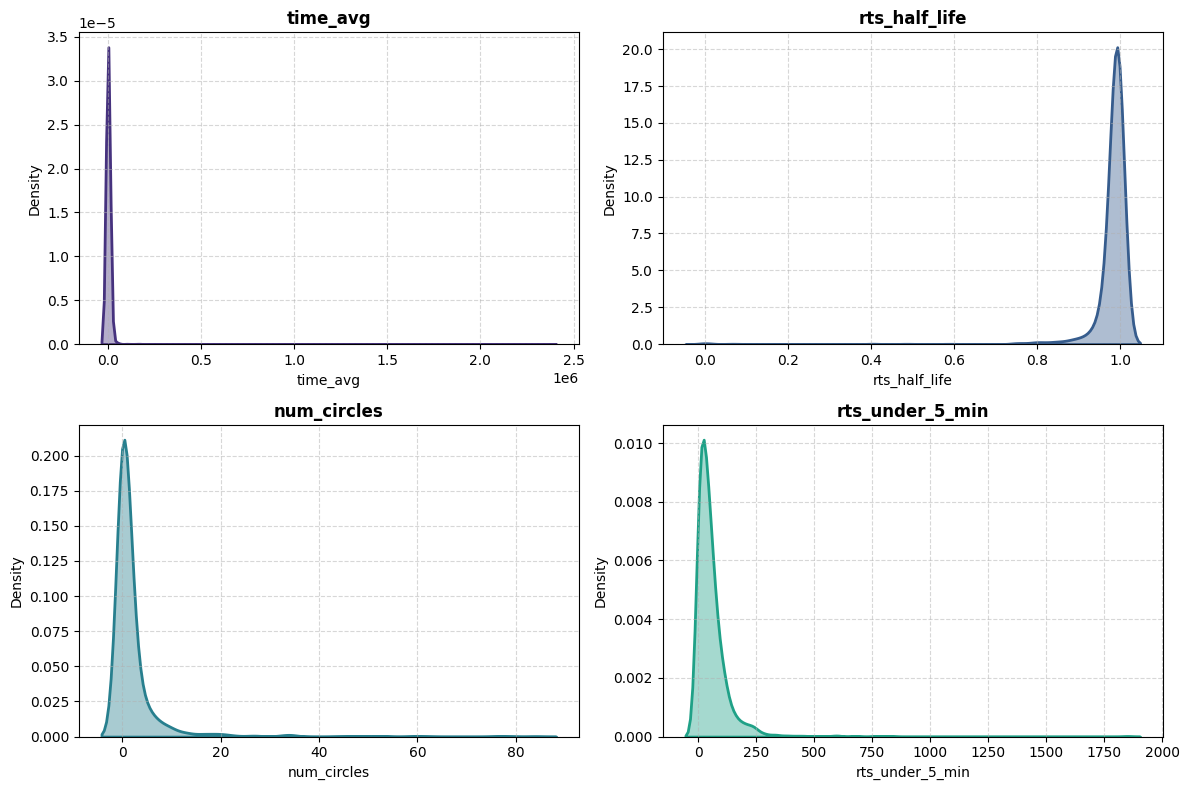

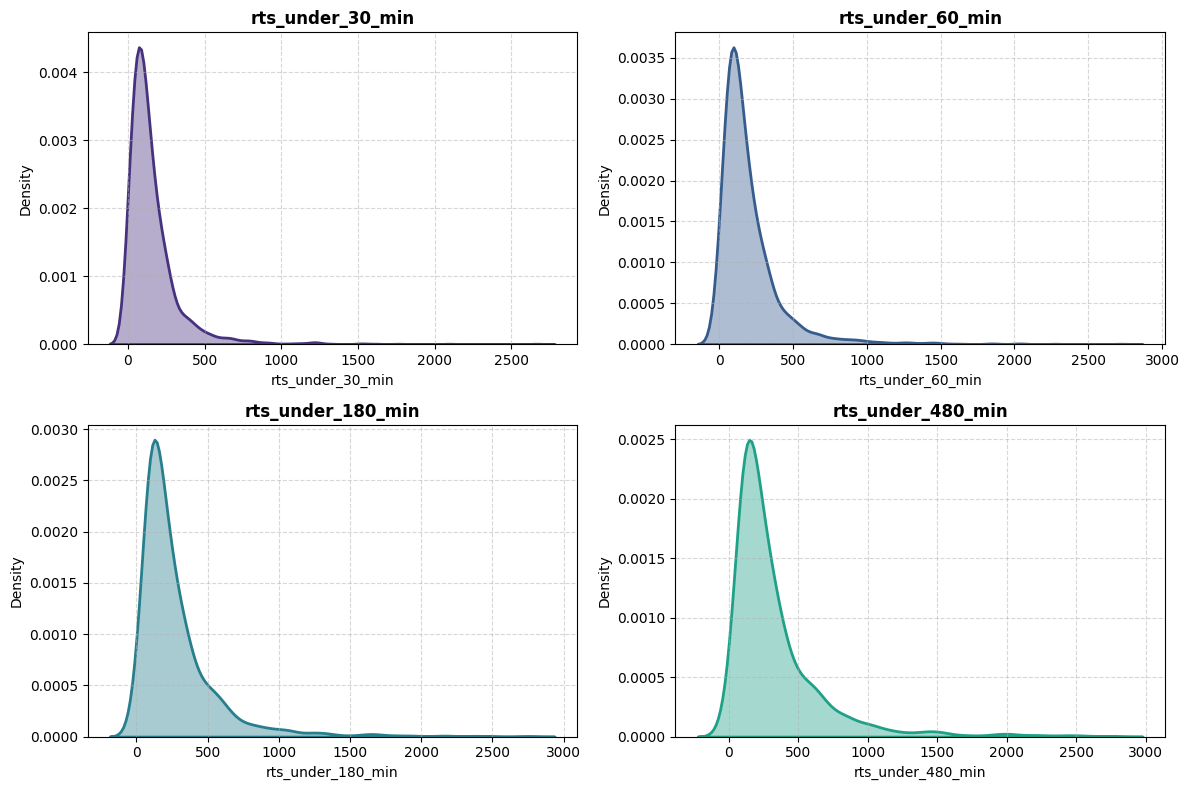

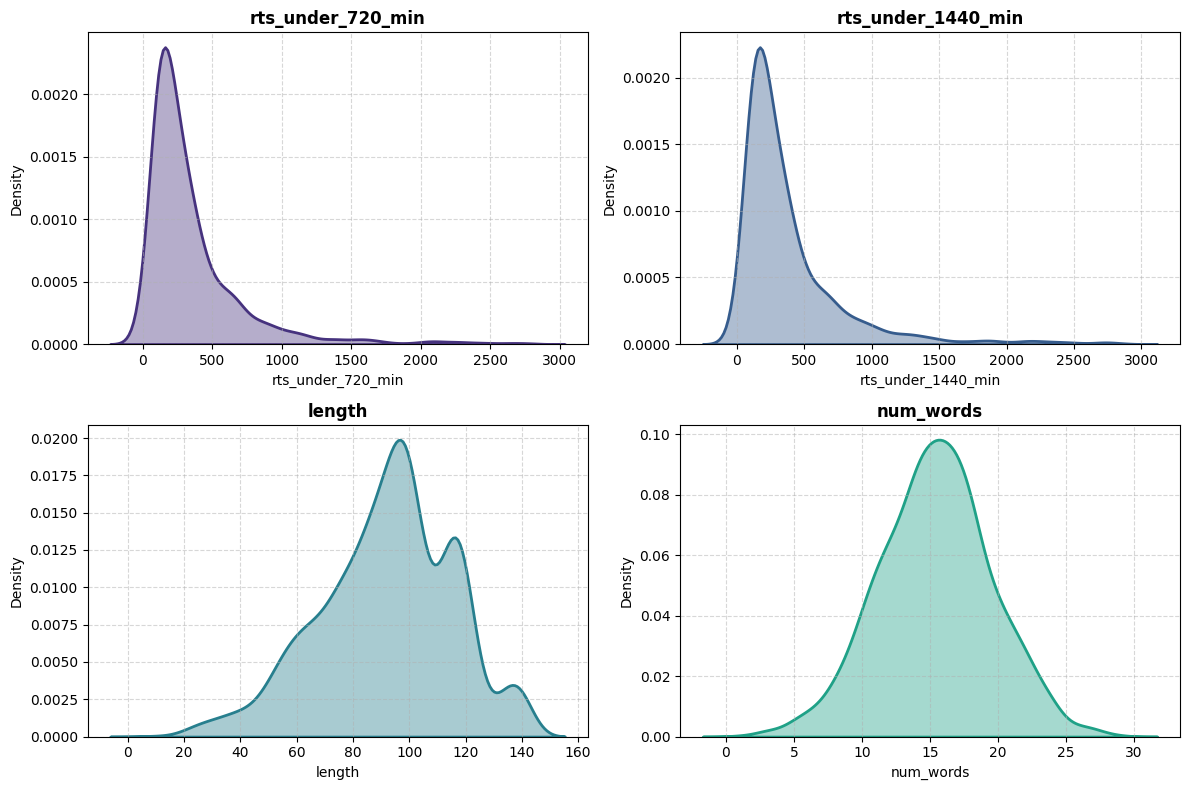

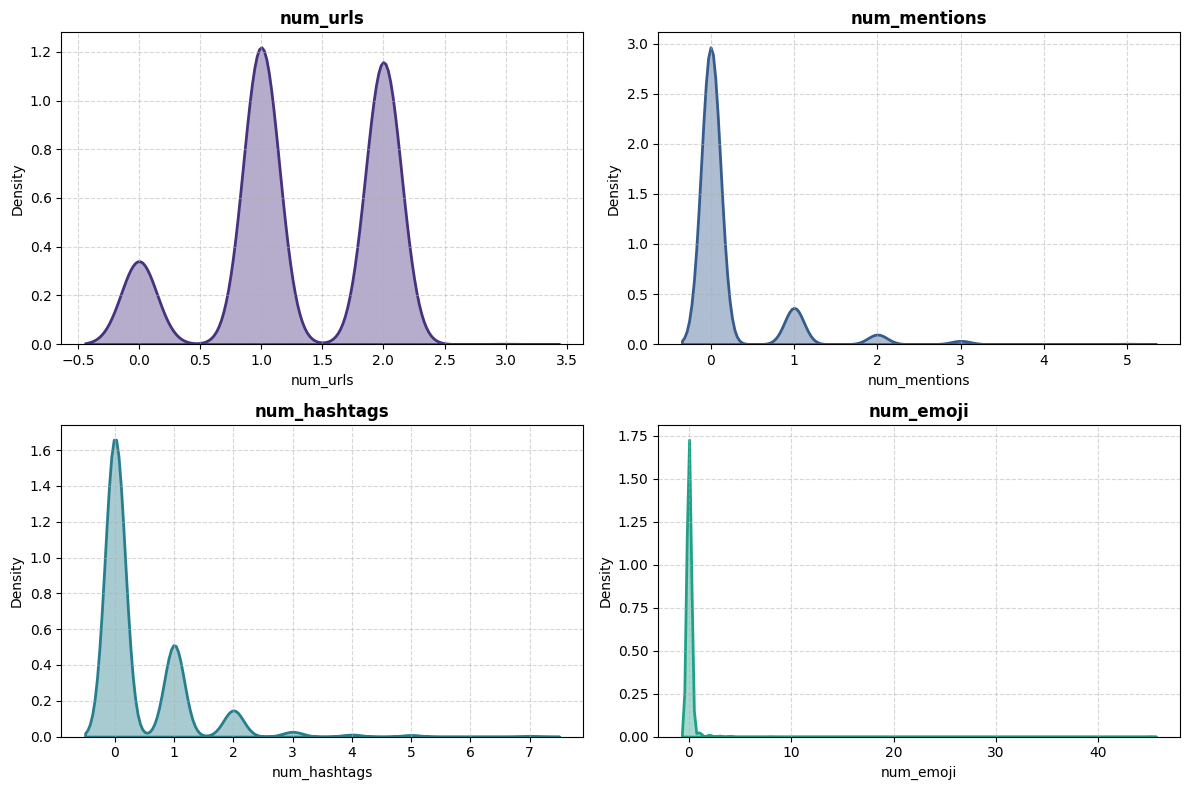

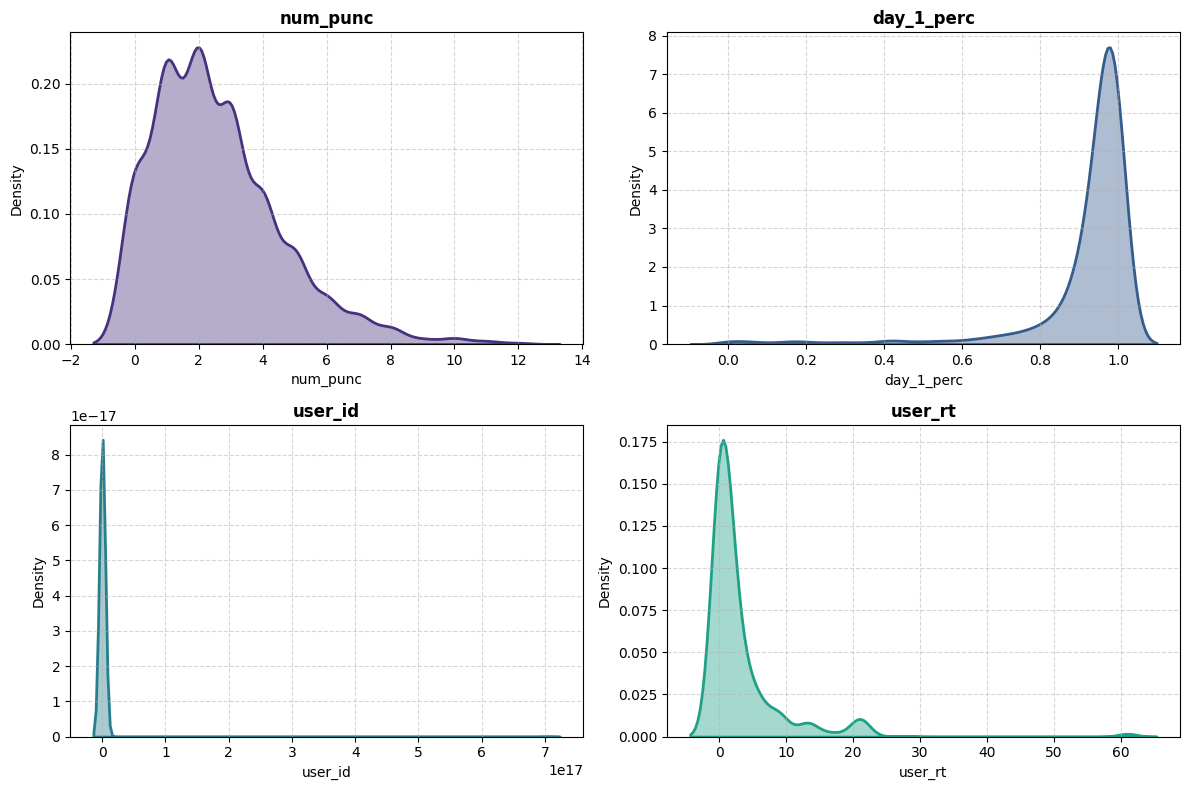

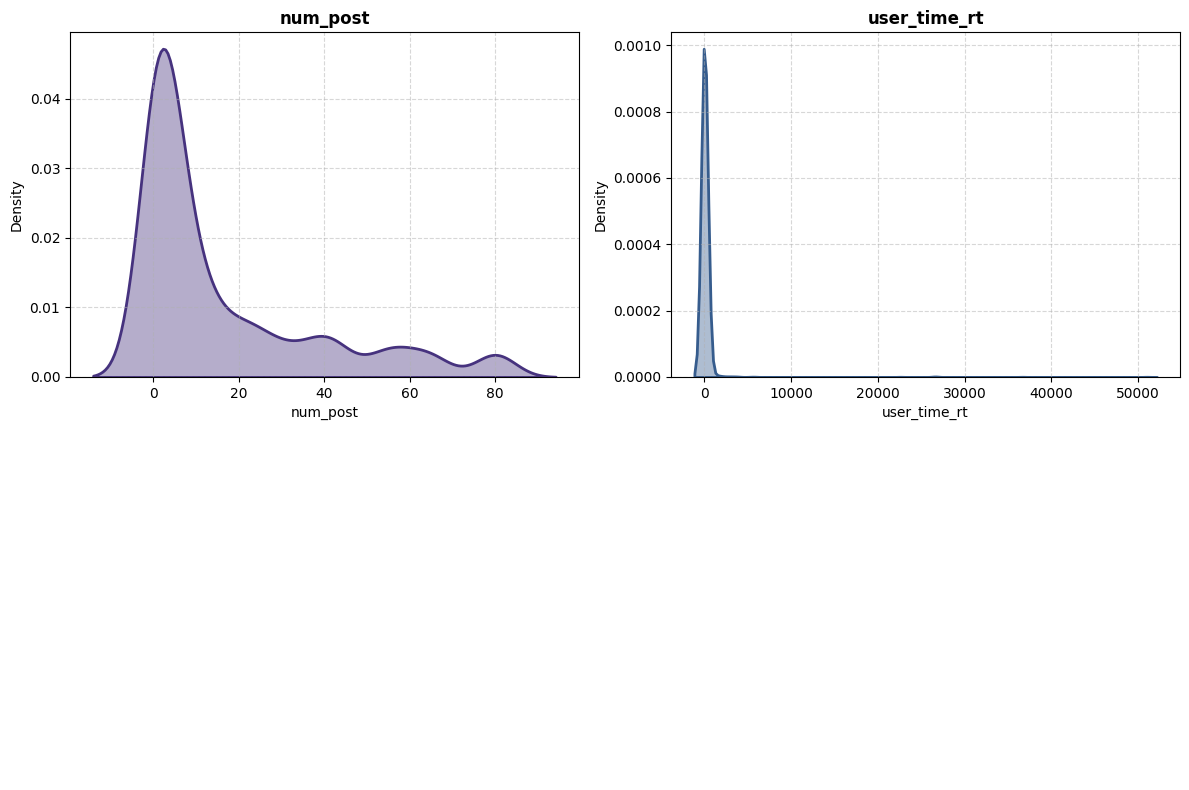

In [19]:
# distributions
import math

def plot_multiple_dists(df, plots_per_fig=4):

    columns = [col for col in df.columns if col not in EXCLUDE_COLUMNS]
    columns.remove("tweet_id")

    n = len(columns)
    plots_per_row = 2
    plots_per_col = plots_per_fig // plots_per_row
    num_figs = math.ceil(n / plots_per_fig)

    for fig_idx in range(num_figs):
        fig, axs = plt.subplots(plots_per_col, plots_per_row, figsize=(12, 8))
        axs = axs.flatten()

        for i in range(plots_per_fig):
            col_idx = fig_idx * plots_per_fig + i
            if col_idx >= n:
                axs[i].axis('off')
                continue

            col = columns[col_idx]
            sns.kdeplot(
                df[col],
                fill=True,
                ax=axs[i],
                alpha=0.4,
                linewidth=2,
                color=sns.color_palette("viridis", as_cmap=False)[i % 10]
            )
            axs[i].set_title(col, fontsize=12, fontweight='bold')
            axs[i].tick_params(axis='both', labelsize=10)
            axs[i].grid(True, linestyle='--', alpha=0.5)


        plt.tight_layout()
        plt.show()

plot_multiple_dists(df)

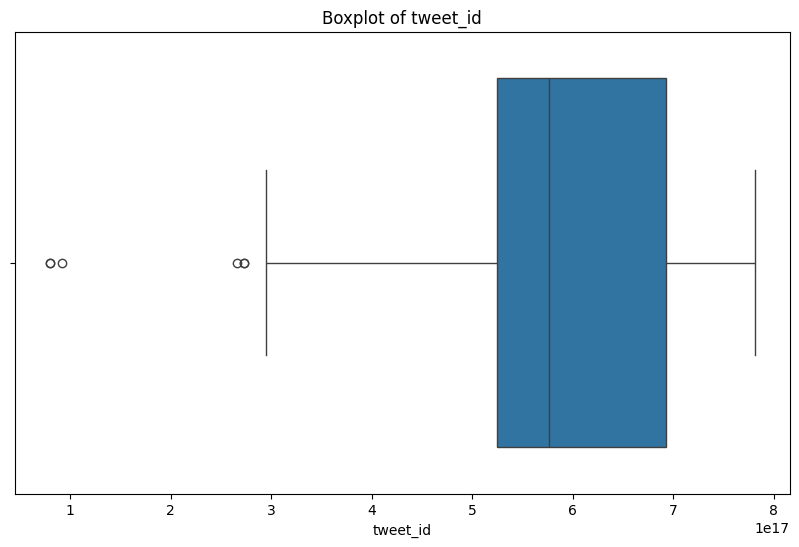

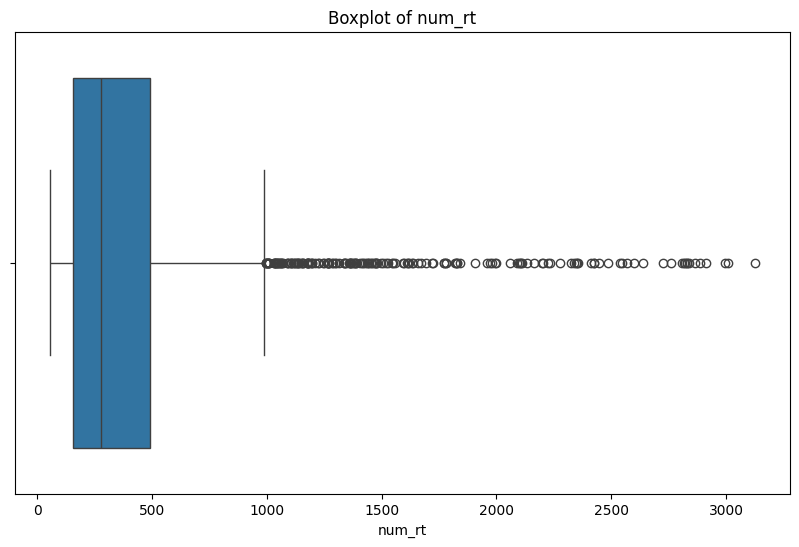

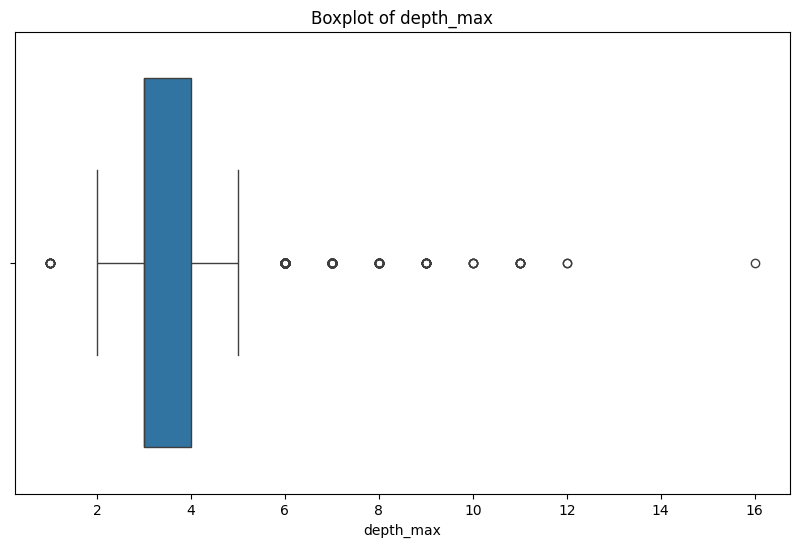

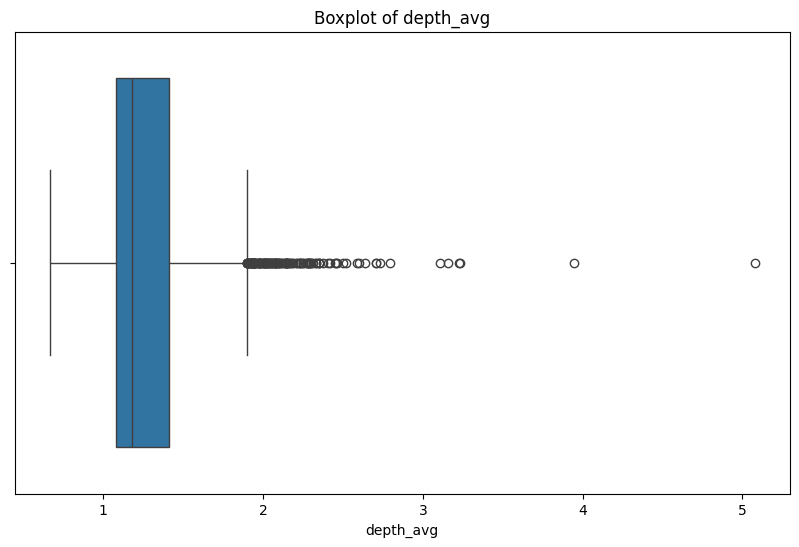

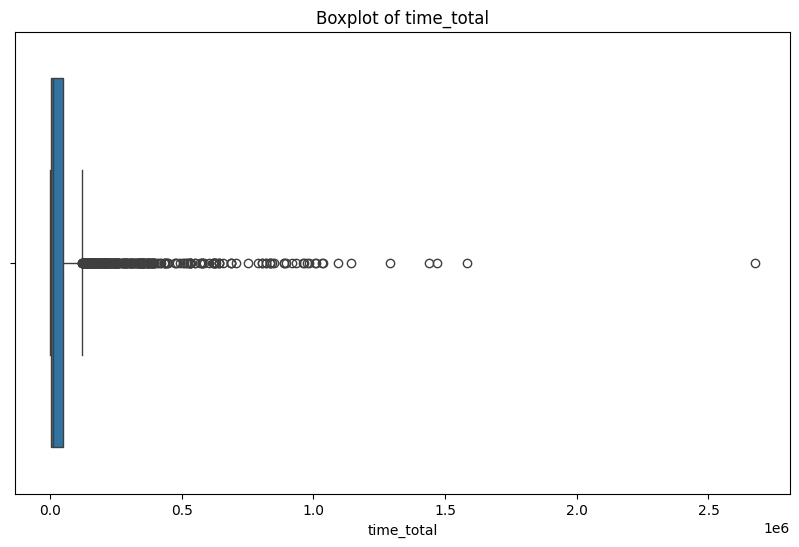

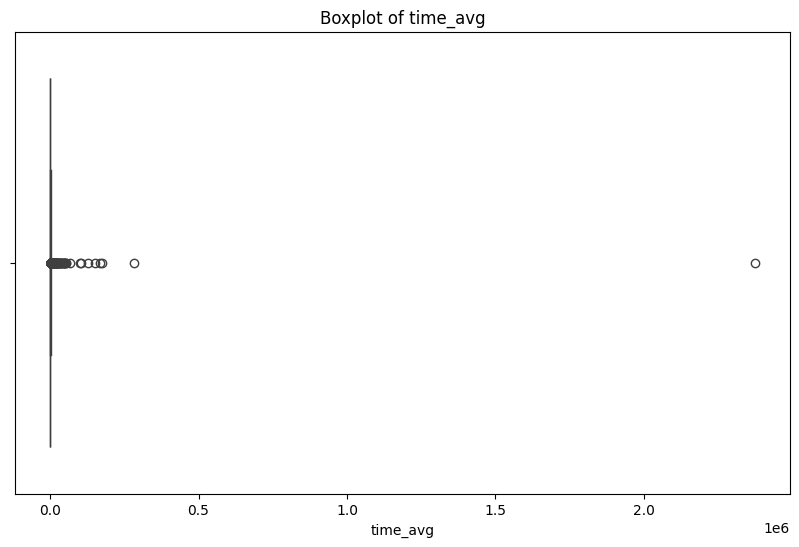

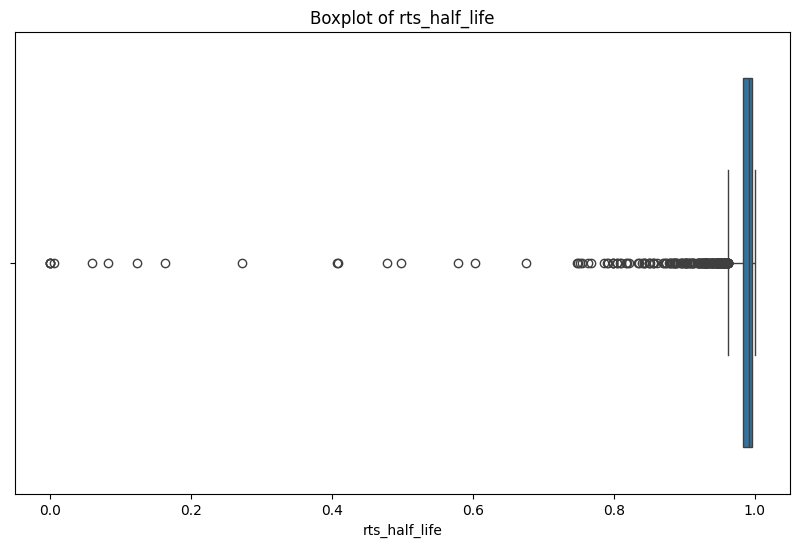

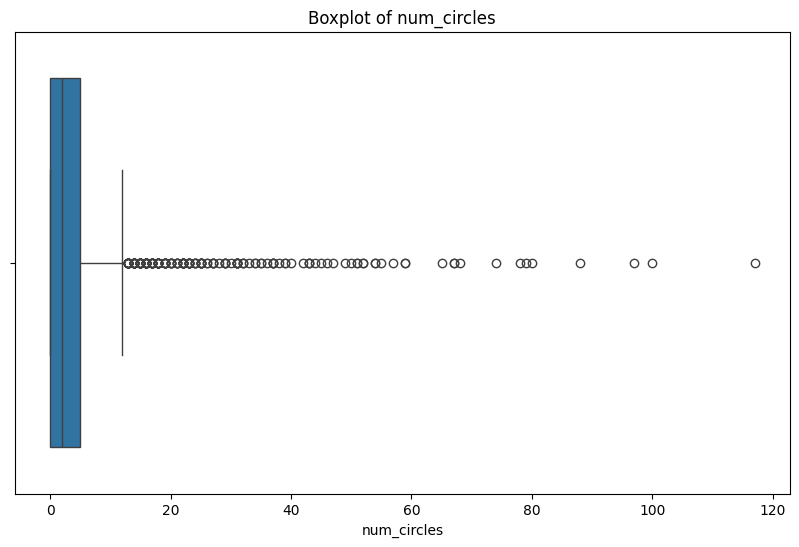

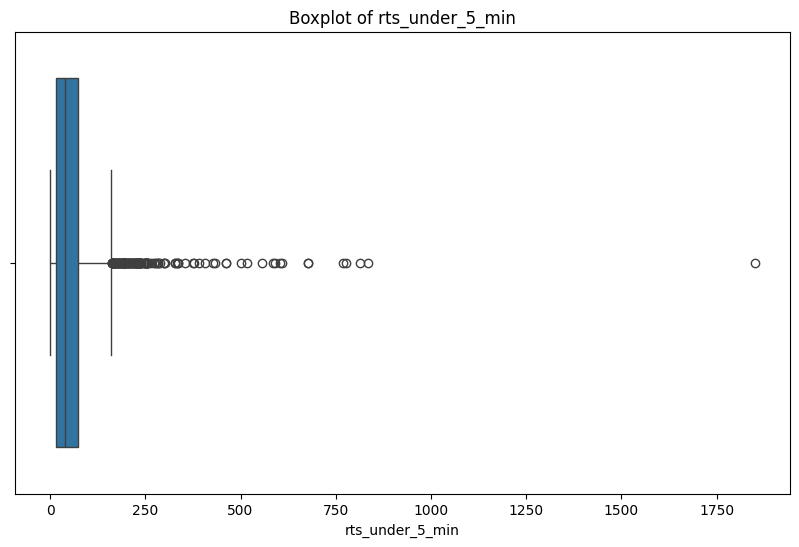

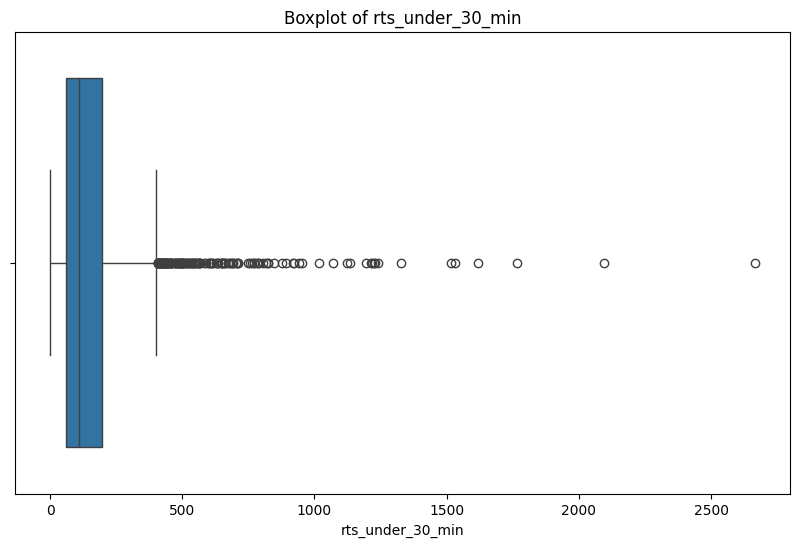

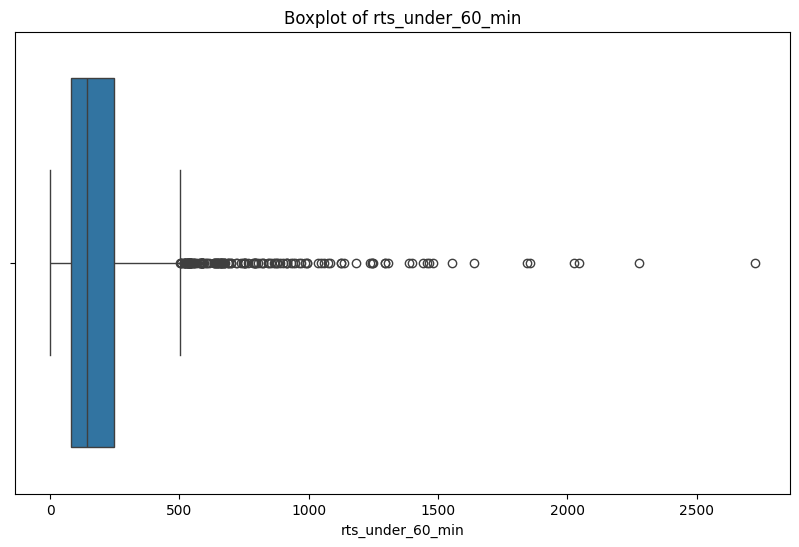

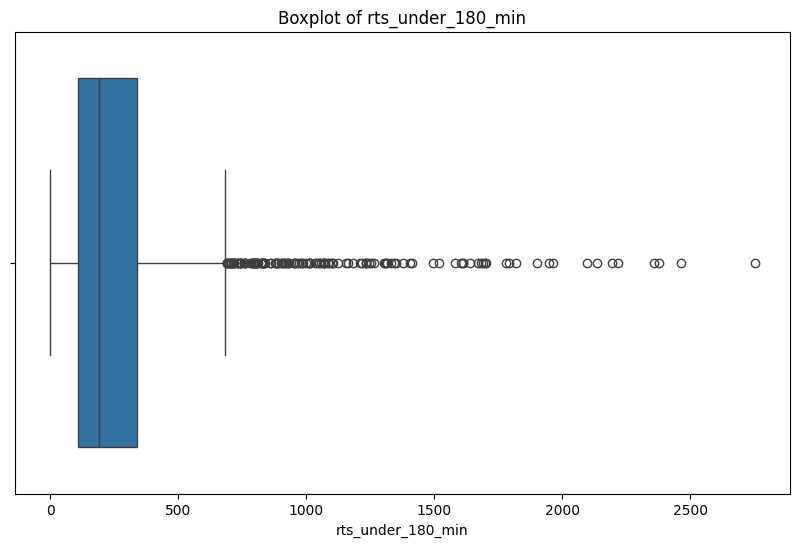

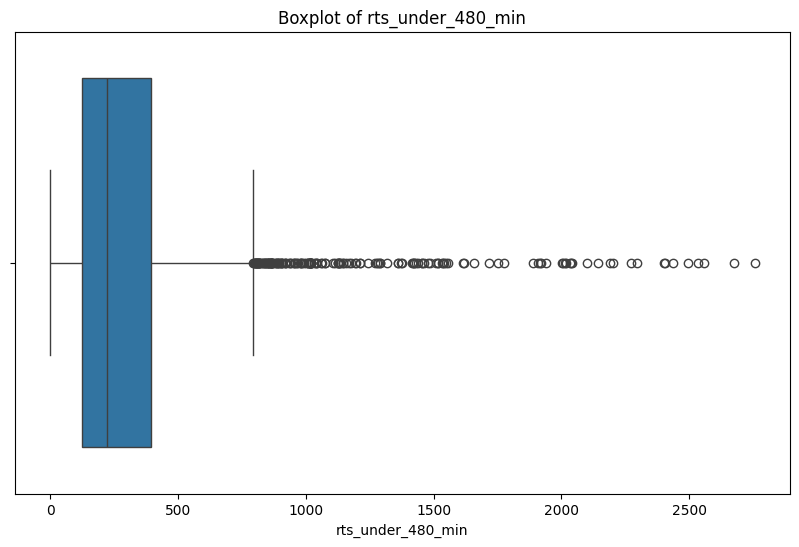

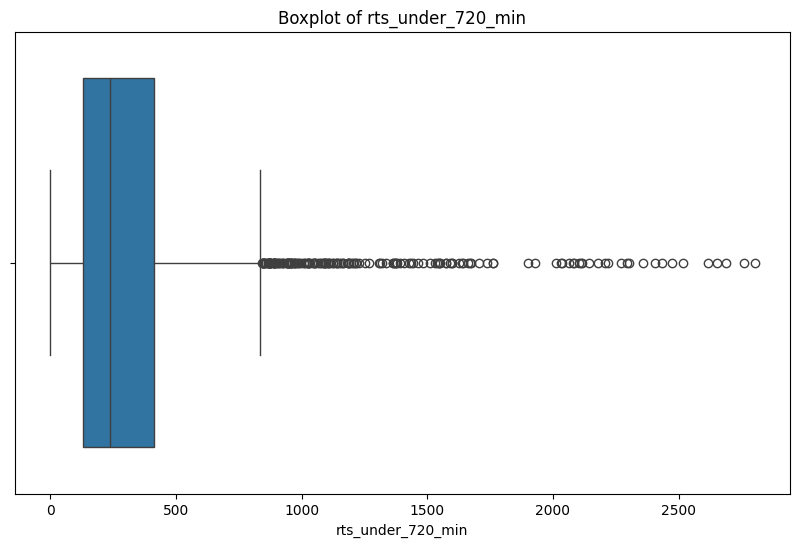

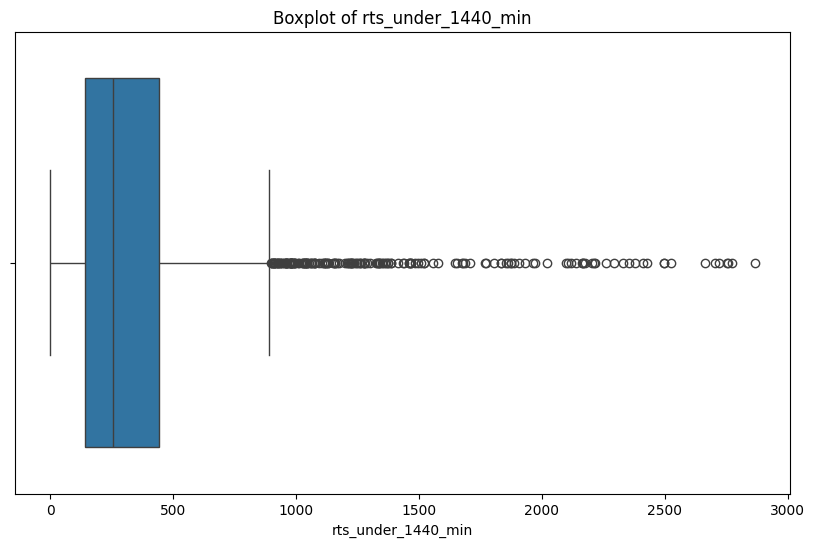

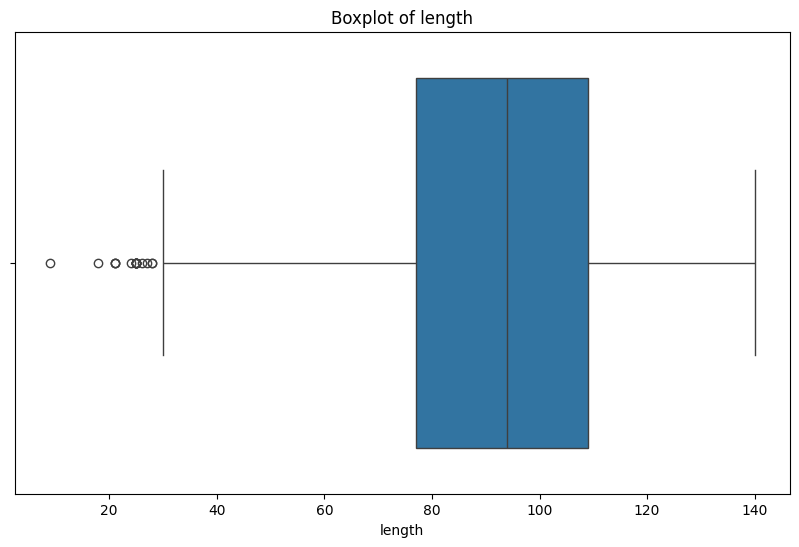

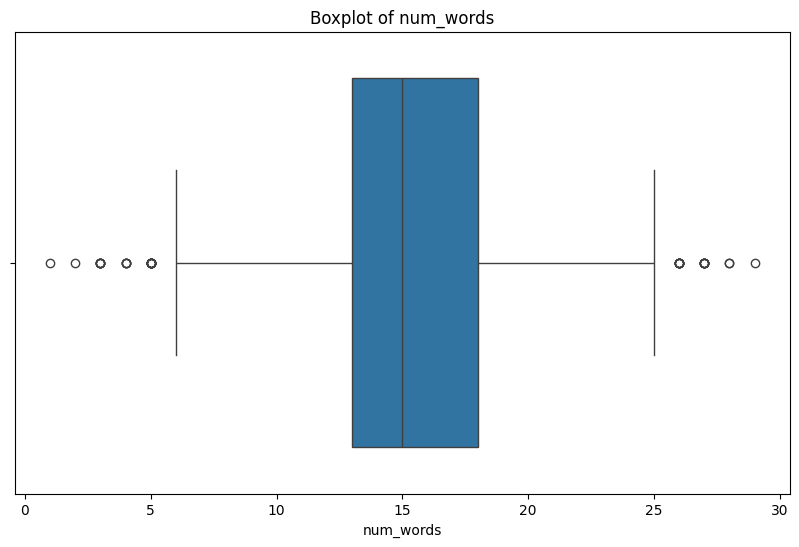

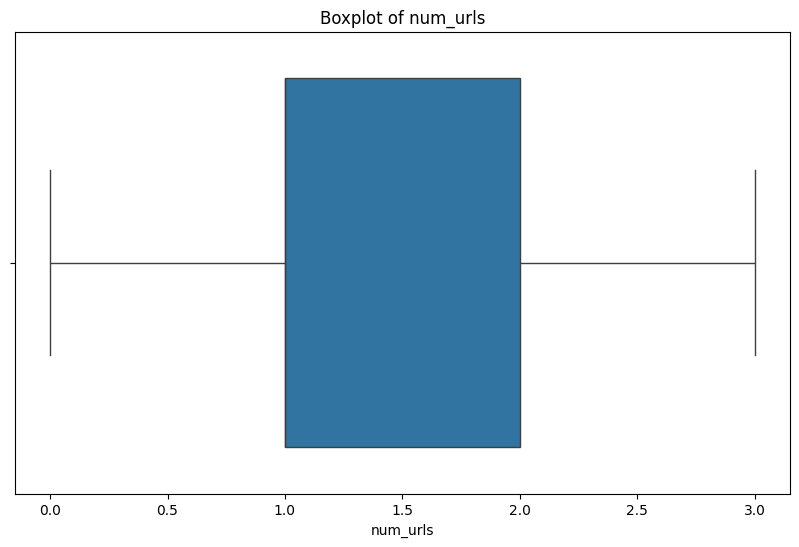

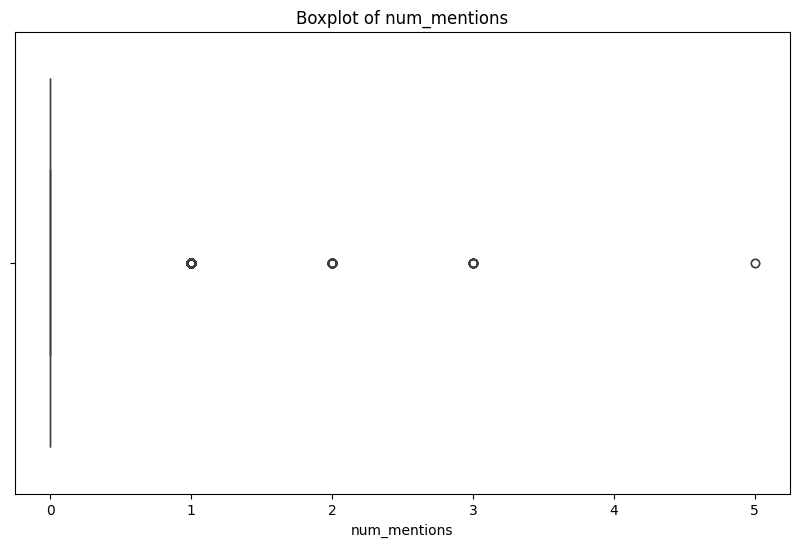

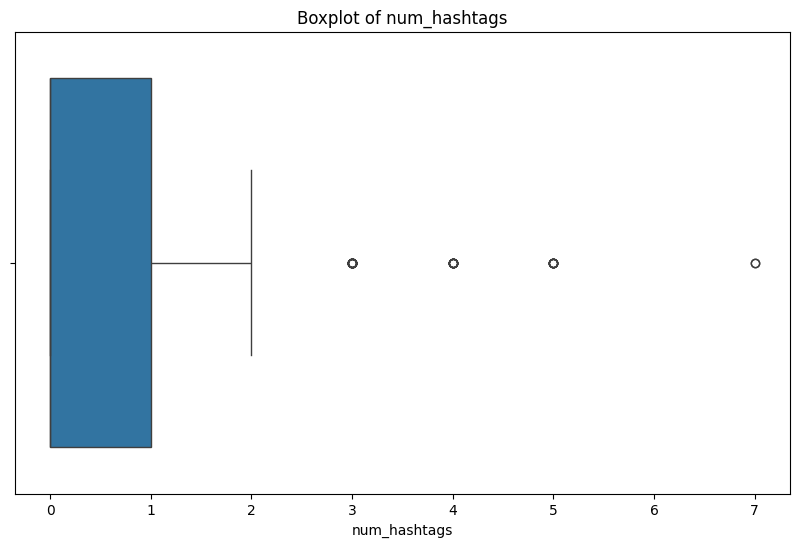

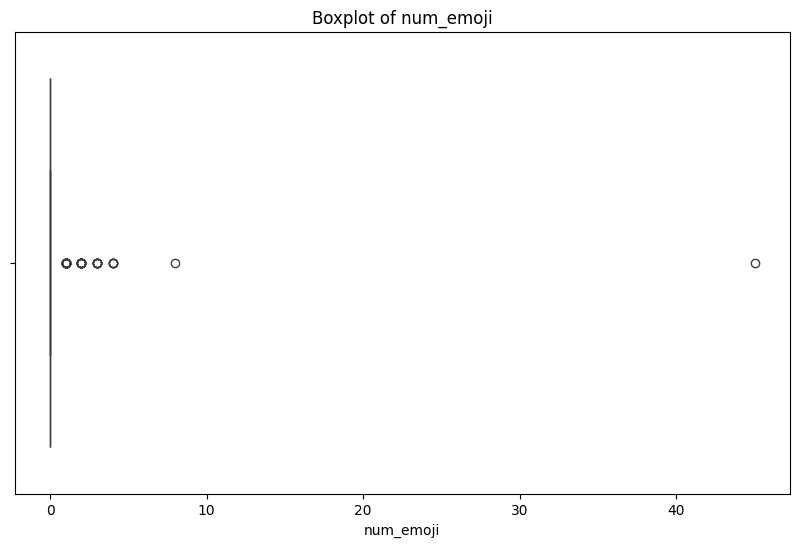

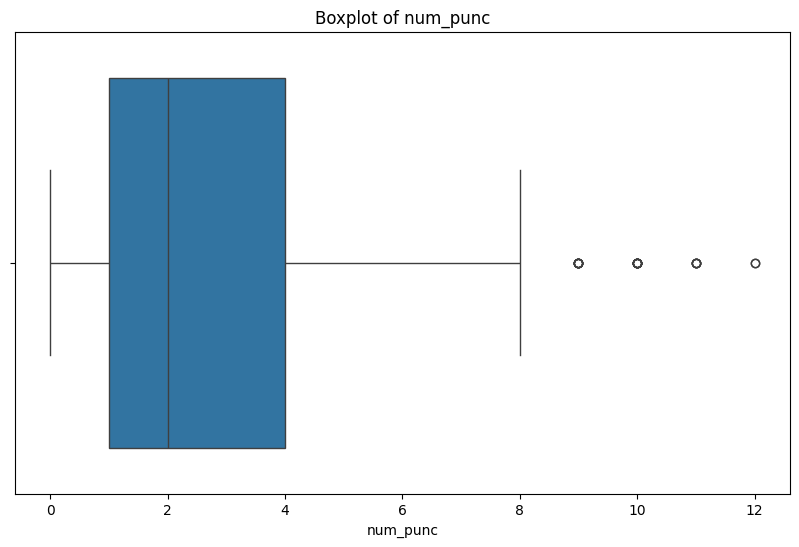

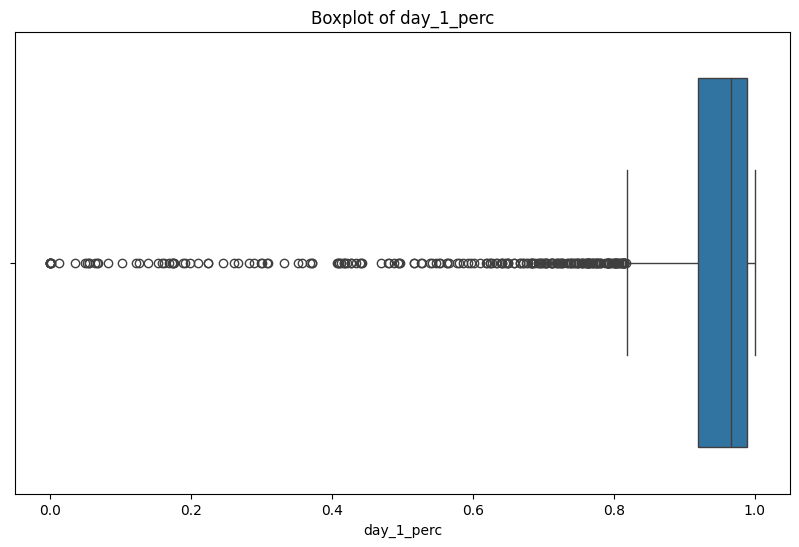

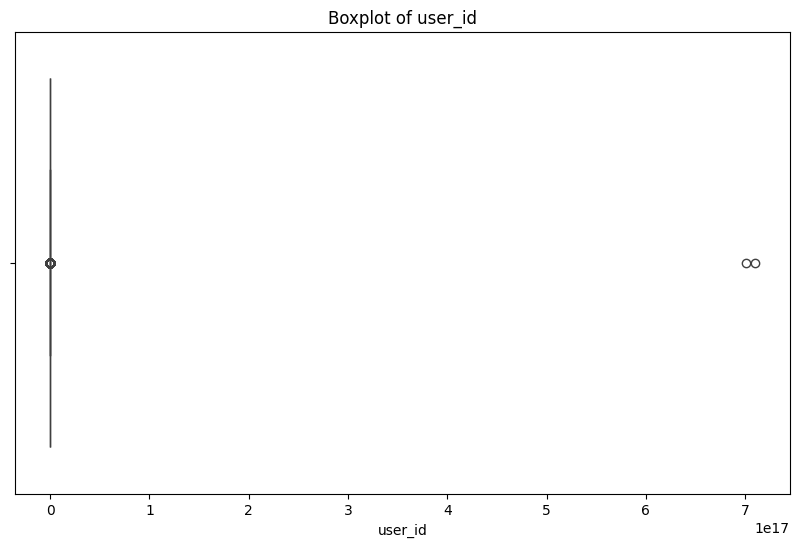

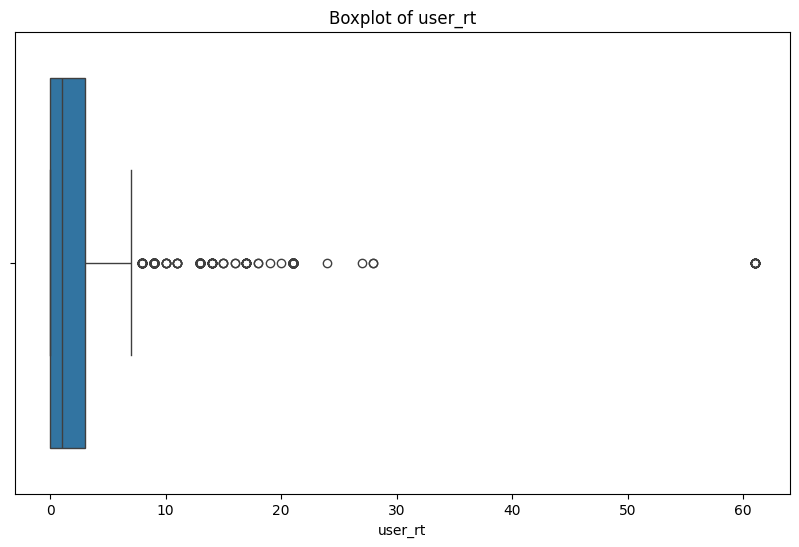

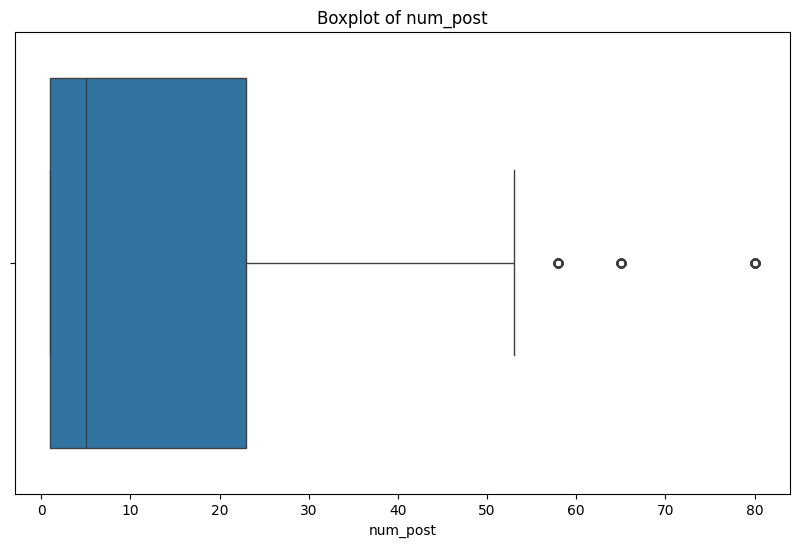

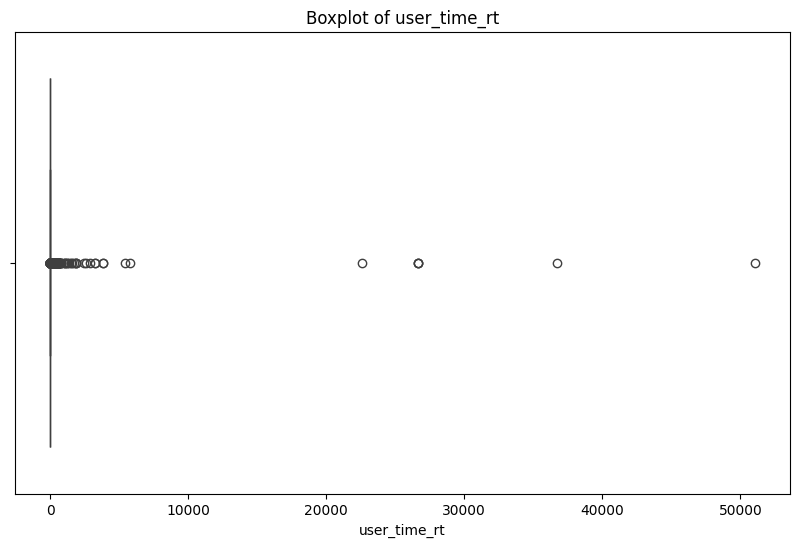

In [15]:
# box plots
def boxplot(df, column):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[column])
    plt.title(f"Boxplot of {column}")
    plt.show()
    
    return None


def boxplots(df):        
    df_filtered = df.drop(columns=EXCLUDE_COLUMNS)
    
    for c in df_filtered.columns:
        boxplot(df, c)

    return None

boxplots(df)

In [16]:
# skewness
def calc_skewness(df):
    df_filtered = df.drop(columns=EXCLUDE_COLUMNS)
    
    skewness = df_filtered.skew()
    skewness = skewness.sort_values(ascending=False)
    
    table = PrettyTable()
    table.field_names = ["Feature", "Skewness"]
    for c, skew in skewness.items():
        table.add_row([c, round(skew, 4)])

    print(table)

    return skewness
    
skewness = calc_skewness(df)

+--------------------+----------+
|      Feature       | Skewness |
+--------------------+----------+
|      time_avg      | 43.6034  |
|     num_emoji      | 38.7978  |
|      user_id       | 32.6822  |
|    user_time_rt    | 20.8427  |
|  rts_under_5_min   |  7.4505  |
|     time_total     |  5.3995  |
|    num_circles     |  5.0305  |
|      user_rt       |  4.7234  |
|  rts_under_30_min  |  4.4382  |
|  rts_under_60_min  |  3.8283  |
|    num_mentions    |  3.4286  |
| rts_under_180_min  |  3.2425  |
| rts_under_480_min  |  3.0053  |
| rts_under_720_min  |  2.9547  |
|       num_rt       |  2.8717  |
| rts_under_1440_min |  2.848   |
|    num_hashtags    |  2.7132  |
|     depth_avg      |  2.5952  |
|     depth_max      |  1.5726  |
|      num_post      |  1.5301  |
|      num_punc      |  1.1162  |
|     num_words      |  -0.042  |
|       length       | -0.3624  |
|      tweet_id      | -0.3966  |
|      num_urls      | -0.4495  |
|     day_1_perc     | -3.8239  |
|   rts_half_l

Removed highly correlated: rts_under_30_min
Removed highly correlated: rts_under_60_min
Removed highly correlated: rts_under_180_min
Removed highly correlated: rts_under_480_min
Removed highly correlated: rts_under_720_min
Removed highly correlated: rts_under_1440_min


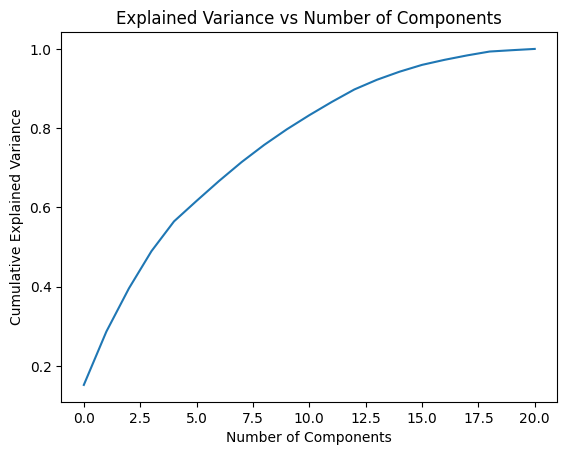

In [17]:
# PCA
def plot_pca(df):
    df_filtered = df.drop(columns=EXCLUDE_COLUMNS)

    df_filtered = remove_corr(df_filtered)
    df_filtered = log_transform(df_filtered)
    df_filtered = StandardScaler().fit_transform(df_filtered)
    
    pca = PCA().fit(df_filtered)
    
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance vs Number of Components')
    plt.show()

    return None

plot_pca(df)

In [18]:
# just true-false
df_true_false = df[(df['label'] == 0) | (df['label'] == 2)].copy()
df_true_false['label'] = df_true_false['label'].replace(2, 1)

df_true_false.to_csv(PATH + 'trueFalse.csv', index=False)

In [19]:
# just binary
# non-rumor  -> true
# unverified -> false

df_bin = df.copy()
df_bin['label'] = df_bin['label'].replace(2, 1)
df_bin['label'] = df_bin['label'].replace(3, 0)

df_bin.to_csv(PATH + 'binary.csv', index=False)

In [20]:
# all labels
df.to_csv(PATH + 'dataset.csv', index=False)

In [21]:
# reset
# df = df_og.copy()
# df = df.drop(columns = ['num_all_caps'])